In this notebook, An Artificial Neural Network or a Convolutional Neural Network is used to classify sceneries from Intel's dataset that contain 6 classes:


*   Buildings

*   Forest

*   Glacier
*   Mountain


*   Sea


*   Street



In [1]:
# Importing our libraries

import time
from timeit import default_timer as timer
import torch
import torchvision
import os
from torch import nn, optim
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torch.utils.data.sampler import SubsetRandomSampler
from collections import OrderedDict
from torchsummary import summary
import torch.nn.functional as F

# Loading bar feature
from tqdm.auto import trange, tqdm

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# For reproduceability
seed = 42
torch.manual_seed(seed)
batch_size=128

device = torch.device("cuda:0")
# device = torch.device("cpu")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Dataset importing from gdrive

In [2]:
# mount google drive into google colab to import the dataset
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Unzipping the dataset into google colab's storage
!unzip "/content/gdrive/My Drive/EE499/Project/Dataset.zip" -d "/Data"

In [0]:
# Specifying Dataset Directory
data_dir = "/Data/499 Project"

# Data Preprocessing
We will load the data and normalize it for better performance on CNNs, ANN data is not normalized.

We will then visualize some images and data.

In [0]:
# display the image and undo the processing if any.
def imshow(image, ax=None, title=None, normalized = True):
    if ax is None:
        fig, ax = plt.subplots()
    
    image = np.transpose(image, (1, 2, 0))  
    # Undo preprocessing
    if normalized:
      mean = np.array([0.4307, 0.4577, 0.4541])
      std = np.array([0.2701, 0.2682, 0.2984])
      image = std * np.array(image) + mean
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    plt.title(title)
    return None

https://gist.github.com/kevinzakka/d33bf8d6c7f06a9d8c76d97a7879f5cb

In [0]:
# Splits the dataset into training, validation, and testing loaders
def get_train_valid_test_loader(data_dir,batch_size,
                           augment,
                           random_seed,
                           valid_size=0.2,
                           test_size = 0.1,
                           shuffle=True,
                           num_workers=4,
                           pin_memory=True):
  # Defining Transforms
  if augment: 
    train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                        transforms.RandomResizedCrop(150),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.4307, 0.4577, 0.4541], 
                                                              [0.2701, 0.2682, 0.2984])])
    valid_transforms = transforms.Compose([transforms.Resize(150),
                                        transforms.CenterCrop(150),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.4307, 0.4577, 0.4541], 
                                                              [0.2701, 0.2682, 0.2984])])

    test_transforms = transforms.Compose([transforms.Resize(150),
                                        transforms.CenterCrop(150),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.4307, 0.4577, 0.4541], 
                                                              [0.2701, 0.2682, 0.2984])])
  else: # for ANN
    train_transforms = transforms.Compose([transforms.Resize(150),
                                        transforms.CenterCrop(150),
                                        transforms.ToTensor()])
    
    valid_transforms = transforms.Compose([transforms.Resize(150),
                                        transforms.CenterCrop(150),
                                        transforms.ToTensor()])

    test_transforms = transforms.Compose([transforms.Resize(150),
                                        transforms.CenterCrop(150),
                                        transforms.ToTensor()])
    
  # Loading datasets
  train_dataset = datasets.ImageFolder(data_dir, transform=train_transforms)
  valid_dataset = datasets.ImageFolder(data_dir, transform=valid_transforms)
  test_dataset = datasets.ImageFolder(data_dir, transform=test_transforms)
  train_nonaug = datasets.ImageFolder(data_dir, transform=valid_transforms)
  
  # Setting the indices
  num_train = len(train_dataset)
  indices = list(range(num_train))
  split_valid = int(np.floor(valid_size * num_train))
  split_test = split_valid + int(np.floor(test_size * num_train))

  # Randomly shuffling the indices
  if shuffle:
      np.random.seed(random_seed)
      np.random.shuffle(indices)
  # Sampling the elements randomly from the indices 
  valid_idx, test_idx, train_idx = indices[:split_valid], indices[split_valid:split_test], indices[split_test:]
  train_sampler = SubsetRandomSampler(train_idx)
  valid_sampler = SubsetRandomSampler(valid_idx)
  test_sampler = SubsetRandomSampler(test_idx)

  # Iterate over the dataset by batches
  train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory)
  valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory)
  test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, sampler=test_sampler,
        num_workers=num_workers, pin_memory=pin_memory)
  train_nonaug_loader = torch.utils.data.DataLoader(
        train_nonaug, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory)
  
  # How many samples are in each split
  print("Number of training samples: {:d}\nNumber of validation samples: {:d}\nNumber of test samples: {:d}".format(len(train_idx),len(valid_idx),len(test_idx)))
  return train_loader, valid_loader, test_loader, train_nonaug_loader

In [6]:
# Loading the data
train_loader, valid_loader, test_loader, train_nonaug_loader = get_train_valid_test_loader(data_dir,batch_size,True, seed) # augment True for CNN, False for ANN

Number of training samples: 11925
Number of validation samples: 3406
Number of test samples: 1703


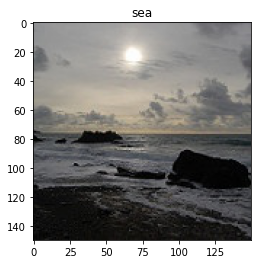

In [7]:
# Check the images from our testing loader
classes = ["buildings", "forest", "glacier", "mountain", "sea", "street"]
dataiter = iter(test_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[0]),title=classes[labels[0]], normalized = True) # normalized = True for augmented (CNN), false for non augmented (ANN)

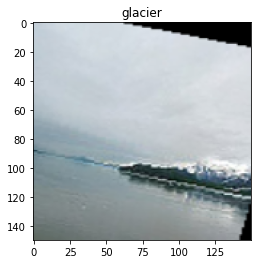

In [8]:
# Check the images from our training loader
classes = ["buildings", "forest", "glacier", "mountain", "sea", "street"]
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[0]),title=classes[labels[0]], normalized = True) # normalized = True for augmented (CNN), false for non augmented (ANN)

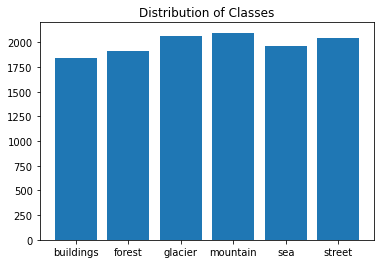

The mean of the distribution is: 1987.50
The standard deviation of the distribution is: 90.96


In [13]:
# Show distribution of classes
def get_class_distribution(loader):
  count = {
        "buildings": 0,
        "forest": 0,
        "glacier": 0,
        "mountain": 0,
        "sea": 0,
        "street": 0,
    }
  for data in loader:
    images, labels = data
    count["buildings"] += (0 == labels).sum().item()
    count["forest"] += (1 == labels).sum().item()
    count["glacier"] += (2 == labels).sum().item()
    count["mountain"] += (3 == labels).sum().item()
    count["sea"] += (4 == labels).sum().item()
    count["street"] += (5 == labels).sum().item()
  return count

count = get_class_distribution(train_loader)
plt.bar(range(len(count)), list(count.values()), align='center')
plt.xticks(range(len(count)), list(count.keys()))
plt.title("Distribution of Classes")
plt.show()
print("The mean of the distribution is: {:.2f}\nThe standard deviation of the distribution is: {:.2f}".format(np.array(list(count.values())).mean(),np.array(list(count.values())).std()))

# Setting up models

In [0]:
# ANN, couldn't experiment more due to the large number of trainable parameters and GPU memory restraints
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.drop = nn.Dropout(p=0.1)
        self.fc1 = nn.Linear(67500, 4096)
        self.fc2 = nn.Linear(4096,1024)
        self.fc3 = nn.Linear(1024,256)
        self.fc4 = nn.Linear(256,6)
        self.activation = nn.ReLU()
        self.out = nn.LogSoftmax(dim=1)
    def forward(self,x):
      x = x.view(x.size(0),-1) # flatten image
      x = self.fc1(x)
      x = self.activation(x)
      x = self.drop(x)
      x = self.fc2(x)
      x = self.activation(x)
      x = self.drop(x)
      x = self.fc3(x)
      x = self.activation(x)
      x = self.drop(x)
      x = self.fc4(x)
      x = self.out(x)
      return x

In [0]:
 # mini batch size = 128, lower batches resulted in slower convergence and higher batches weren't feasible due to GPU memory limitations
kernel = 5
padding = 2 # padding is used to retain the information in the edges and to keep the input's dimensions the same.
# more layers werent feasible due to maxpooling reducing the size of the feature planes to small dimensions. 
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,64,kernel_size = kernel,padding=padding),#output 64,150,150
            nn.ReLU(inplace=True), # to save memory
            nn.Conv2d(64,64,kernel_size = kernel,padding=padding),#output 64,150,150
            nn.ReLU(inplace=True),
            nn.Conv2d(64,64,kernel_size = kernel,padding=padding),#output 64,150,150
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),#output 64,75,75
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64,128,kernel_size = kernel,padding=padding),#output 128,75,75
            nn.ReLU(inplace=True),
            nn.Conv2d(128,128,kernel_size = kernel,padding=padding),#output 128,75,75
            nn.ReLU(inplace=True),
            nn.Conv2d(128,128,kernel_size = kernel,padding=padding),#output 128,75,75
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),#output 128,37,37
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128,256,kernel_size = kernel,padding=padding),#output 256,37,37
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size = kernel,padding=padding),#output 256,37,37
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size = kernel,padding=padding),#output 256,37,37
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),#output 256,18,18

        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256,512,kernel_size = kernel,padding=padding),#output 512,18,18
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size = kernel,padding=padding),#output 512,18,18
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size = kernel,padding=padding),#output 512,18,18
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),#output 512,9,9
        )
        self.drop = nn.Dropout(p=0.4) # for regularization 
        self.fc1 = nn.Linear(512*9*9, 3456)
        self.fc2 = nn.Linear(3456, 6)
        self.activation = nn.ReLU()
        self.out = nn.LogSoftmax(dim=1)
    def forward(self,x): # forward path
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)
      x = x.view(x.size(0),-1) # flatten input
      x = self.fc1(x) # feeding extracted features to linear layers for classification
      x = self.activation(x)
      x = self.drop(x)
      x = self.fc2(x)
      x = self.out(x)
      return x

In [18]:
model = ANN() # ANN model initialization
# send model to GPU
model.to(device)

ANN(
  (drop): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=67500, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=6, bias=True)
  (activation): ReLU()
  (out): LogSoftmax()
)

In [11]:
model = ConvNet() # CNN model initialization
# send model to GPU
model.to(device)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU(inplace=True)
    (4): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(

In [19]:
# Get a summary of the model and the number of trainable parameters
summary(model, input_size=(3, 150, 150), batch_size=batch_size, device='cuda')
print('GPU:', torch.cuda.get_device_name(0))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [128, 4096]     276,484,096
              ReLU-2                [128, 4096]               0
           Dropout-3                [128, 4096]               0
            Linear-4                [128, 1024]       4,195,328
              ReLU-5                [128, 1024]               0
           Dropout-6                [128, 1024]               0
            Linear-7                 [128, 256]         262,400
              ReLU-8                 [128, 256]               0
           Dropout-9                 [128, 256]               0
           Linear-10                   [128, 6]           1,542
       LogSoftmax-11                   [128, 6]               0
Total params: 280,943,366
Trainable params: 280,943,366
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 32.96

In [0]:
# Set the criterion as Negative Log Likelihood
criterion = nn.NLLLoss()

# Using Adam as an optimizer
optimizer = optim.Adam(model.parameters())

In [0]:
# Function to get the loss and accuracy 
def validation(model, testloader, criterion):
  # Initializing
  test_loss = 0
  accuracy = 0
  for ii, (inputs, labels) in enumerate(testloader):
    
    # Load the data into CUDA
    inputs, labels = inputs.to(device), labels.to(device)

    # Get the logarithmic probability of each class
    output = model.forward(inputs)
    # Keep summing the loss
    test_loss += criterion(output, labels).item()
    
    # Get the probablity of each class
    ps = torch.exp(output)

    # Aquire the accuracy by comparing the predictions
    equality = (labels.data == ps.max(dim=1)[1])
    accuracy += equality.type(torch.FloatTensor).mean()
  return test_loss, accuracy

In [0]:
# Training with early stopping (Main)
save = '/Data/model.pt'
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file,
          early_stop_epochs=7,
          epochs = 30):
  # Training Initilizing
  start_training_time = time.time()
  start = time.time()
  history = []
  epochs_no_improve = 0
  valid_loss_min = np.Inf
  valid_max_acc = 0

  print("The training process has started. \n")
  for e in range(epochs):
    # Initilizing for each epoch
      running_loss = 0
      model.train() 
      total_train = 0
      correct_train = 0
      
      # Using tqdm's loading bar when iterating through the data
      for ii, (inputs, labels) in tqdm(enumerate(train_loader),total=len(train_loader),desc='Epoch progress'):
          
          # Load the the data into CUDA
          inputs, labels = inputs.to(device), labels.to(device)

          # Setting the gradients to zero
          optimizer.zero_grad()
          
          # Forward and backward passes
          outputs = model.forward(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          
          running_loss += loss.item()
          
          # Obtain the training loss and accuracy of the model
          _, predicted = torch.max(outputs,1)
          total_train += labels.nelement()
          correct_train += predicted.eq(labels).sum().item()
          train_acc = correct_train/total_train

      # Get the validation loss and accuracy
      model.eval()
      with torch.no_grad():
          valid_loss, valid_acc = validation(model, valid_loader, criterion)
      # Print the losses and accuracies
      print("Epoch: {}/{} | ".format(e+1, epochs),
            "Training Loss: {:.4f} | ".format(running_loss/len(train_loader)),
            "Training Accuracy: {:.2f}% |".format(100*train_acc),
            "Validation Loss: {:.4f} | ".format(valid_loss/len(valid_loader)),
            "Validation Accuracy: {:.2f}% |".format(100*valid_acc/len(valid_loader)),
            "Time elapsed: {:.2f} seconds".format((time.time()-start)))
      # Obtain current time in seconds.
      start = time.time()
      # Append the losses and accuracies to the history list
      history.append([running_loss/len(train_loader),100*train_acc,valid_loss/len(valid_loader),100*valid_acc/len(valid_loader)])

      # Check if the validaton loss is lower than the minmum recorded loss
      if valid_loss/len(valid_loader) < valid_loss_min:
        # Save the model weights and parameters
        torch.save(model.state_dict(), save_file)
        # Reinitialize counter
        epochs_no_improve = 0
        # Record minimum loss and best accuracy
        valid_loss_min = valid_loss/len(valid_loader)
        valid_best_acc = 100*valid_acc/len(valid_loader)
        best_epoch = e+1
      else:
        # Count up
        epochs_no_improve += 1

        # Early stop the training if number of epochs exceeded the chosen number
        if epochs_no_improve >= early_stop_epochs:
          print("Early Stopping...Total epochs: {}. Best epoch: {} with loss: {:4f} and accuracy: {:.2f}".format(e+1,best_epoch,valid_loss_min,valid_best_acc))
          # Load best model
          model.load_state_dict(torch.load(save_file))
          # Attach optimizer to the model
          model.optimizer = optimizer
          # Convert history to DataFrame
          history = pd.DataFrame(
                    history,
                    columns=['train_loss','train_acc', 'valid_loss', 'valid_acc'])
          return model, history


      model.train()
      
  end_training_time = time.time()
  # Load best model
  model.load_state_dict(torch.load(save_file))
  # Convert history to DataFrame
  history = pd.DataFrame(
    history,
    columns=['train_loss','train_acc', 'valid_loss', 'valid_acc'])
  print('\nTraining of the model was completed in {:.2f} minutes.'.format((end_training_time-start_training_time)/60))
  return model, history

In [0]:
# Set a temporary save directory for the model during training
save = '/Data/model.pt'
# Train the model and obtain the history
model, history = train(model,criterion,optimizer,train_loader,valid_loader,save,early_stop_epochs=10,epochs=100)

# Visualizing the Results

In [0]:
# Plot the training and validation loss vs epochs
fig = plt.figure(figsize=(8, 6))
for c in ['train_loss',
          'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')
plt.show()
fig.savefig('/content/gdrive/My Drive/EE499/Project/Figures/Model_losses.png')

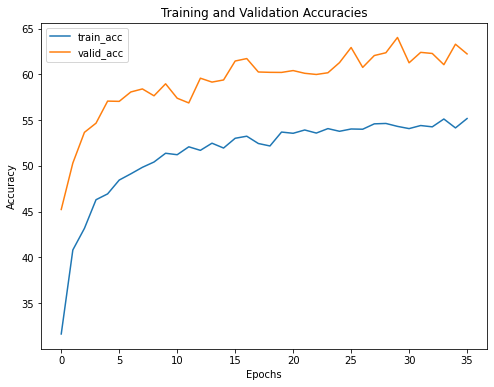

In [25]:
# Plot the training and validation accuracies vs epochs
fig = plt.figure(figsize=(8, 6))
for c in ['train_acc',
          'valid_acc']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.show()
fig.savefig('/content/gdrive/My Drive/EE499/Project/Figures/Model_Accuracies.png')

In [0]:
# Convert the history to an excel file and save it
history.to_excel('/content/gdrive/My Drive/EE499/Project/History/Model_History.xlsx')

In [35]:
# Testing the accuracy of the model
def get_predictions(model, loader):

    model.eval()
    # Initializing
    imagesl = []
    labelsl = []
    probs = []
    with torch.no_grad():

        for (images, labels) in loader:
            # Load the images to CUDA
            images = images.to(device)
            # Get the logarithmic probability
            y_prob = model(images)
            # Get the probability
            y_prob = torch.exp(y_prob)
            # Append the images, labels, and probabilites to their lists
            imagesl.append(images.cpu())
            labelsl.append(labels.cpu())
            probs.append(y_prob.cpu())
    # Convert them to tensors   
    images = torch.cat(imagesl, dim = 0)
    labels = torch.cat(labelsl, dim = 0)
    probs = torch.cat(probs, dim = 0)
    # Get the predicted
    pred_labels = torch.argmax(probs, 1)
    return images, labels, probs, pred_labels
images, labels, probs, pred_labels = get_predictions(model,test_loader)
print('Accuracy achieved by the network on test images is: {:.2f}%'.format(100 *accuracy_score(labels,pred_labels)))

Accuracy achieved by the network on test images is: 63.24%


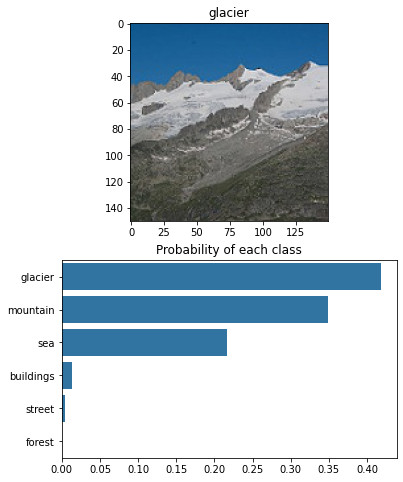

The image was classified correctly.


In [31]:
# Sanity check for the model
with torch.no_grad():
  model.eval()
  # Define the classes
  classes = ["buildings", "forest", "glacier", "mountain", "sea", "street"]
  # Iterator of the loader
  dataiter = iter(test_loader)
  images, labels = dataiter.next()
  plt.figure(figsize=(6,8))
  ax = plt.subplot(2,1,1)
  # Show the image with the label as the title
  imshow(torchvision.utils.make_grid(images[0]), ax, title=classes[labels[0]], normalized = True) # normalized = True for augmented (CNN), false for non augmented (ANN)
  images, labels = images.to(device), labels.to(device)
  outputs = model(images)
  outputs = outputs.cpu()
  # Get the predictions of the first image
  output = (torch.exp(outputs[0]))
  # Obtain the top probabilities with their indices
  prob, idx = torch.topk(output,6)
  plt.subplot(2,1,2)
  # Reorder the classes list to be like the indices
  topsix= [classes[i] for i in idx]
  # Plot the probabilities
  sns.barplot(x=prob, y=topsix,color=sns.color_palette()[0])
  plt.title("Probability of each class")
  plt.show()
  # Print if the image is classified correctly or not
  if labels[0] == idx[0]:
    print("The image was classified correctly.")
  else:
    print("The image was classified incorrectly.")
  

Plotting misclassified data:


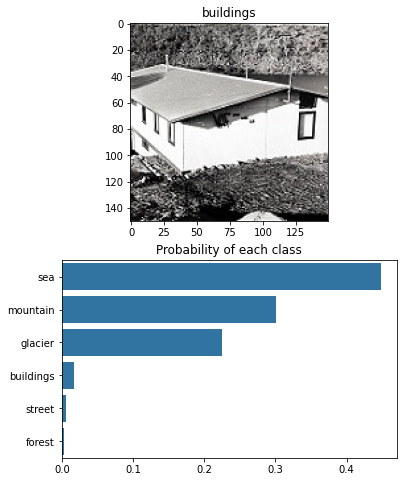

The image was classified incorrectly.


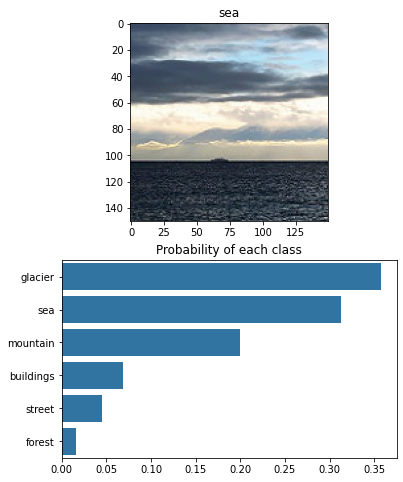

The image was classified incorrectly.


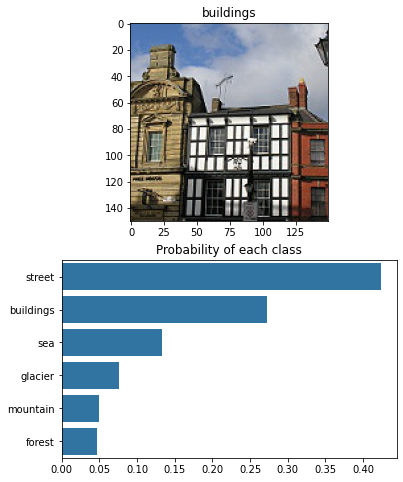

The image was classified incorrectly.


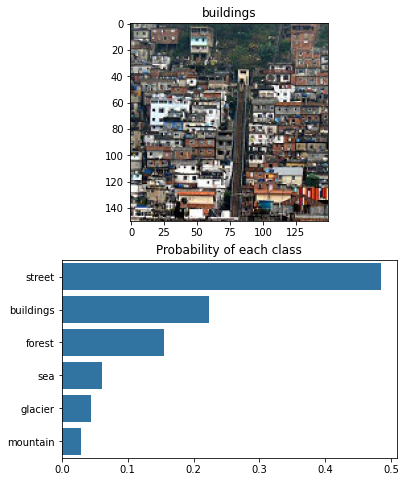

The image was classified incorrectly.


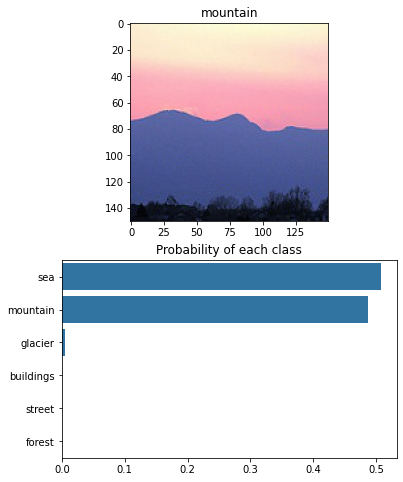

The image was classified incorrectly.


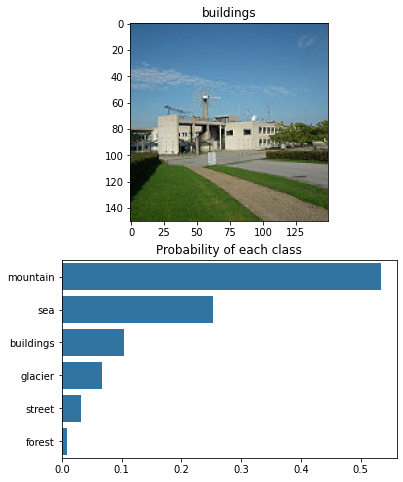

The image was classified incorrectly.


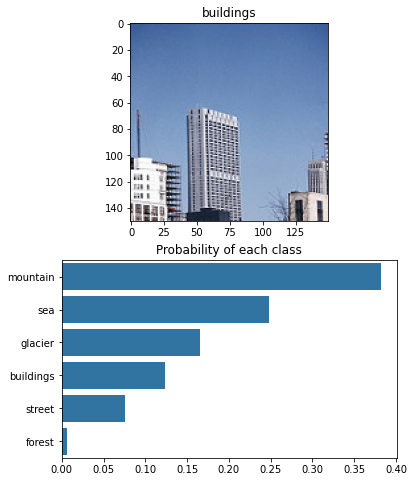

The image was classified incorrectly.


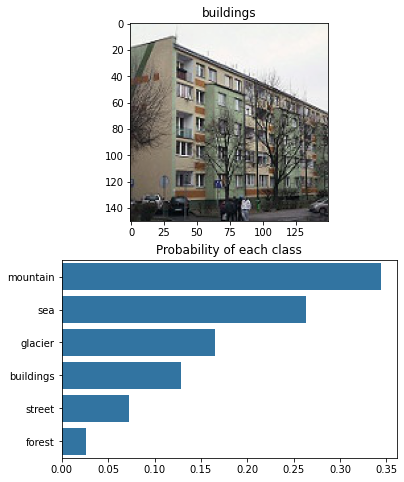

The image was classified incorrectly.


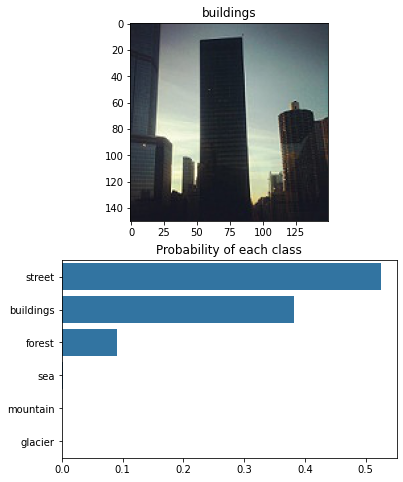

The image was classified incorrectly.


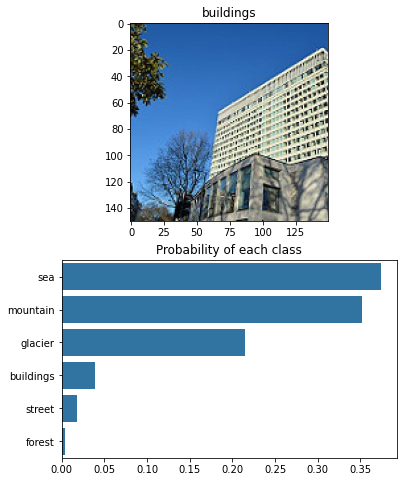

The image was classified incorrectly.


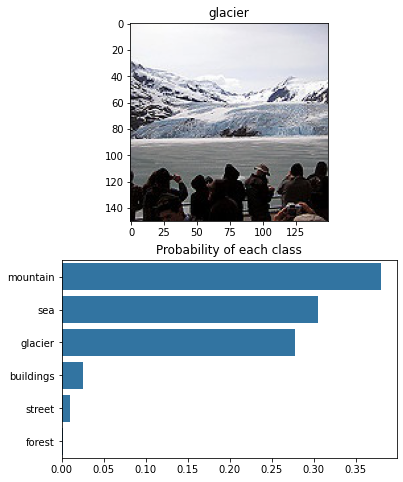

The image was classified incorrectly.


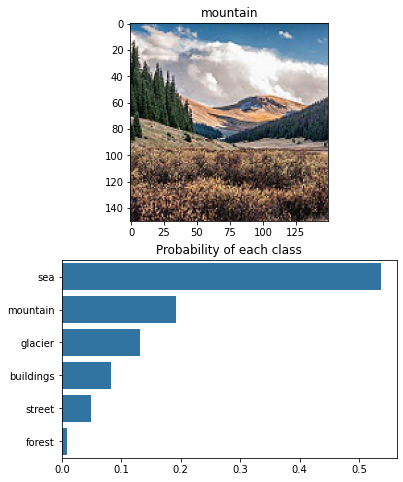

The image was classified incorrectly.


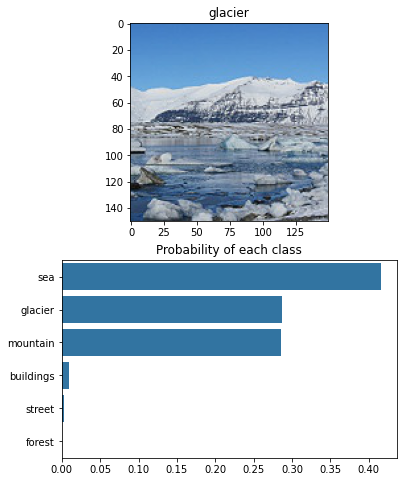

The image was classified incorrectly.


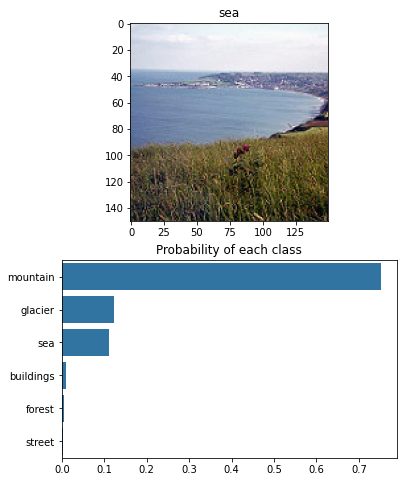

The image was classified incorrectly.


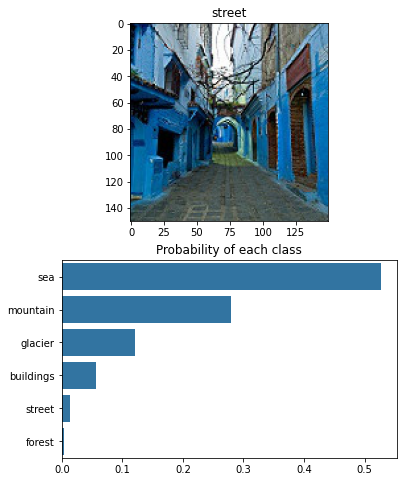

The image was classified incorrectly.


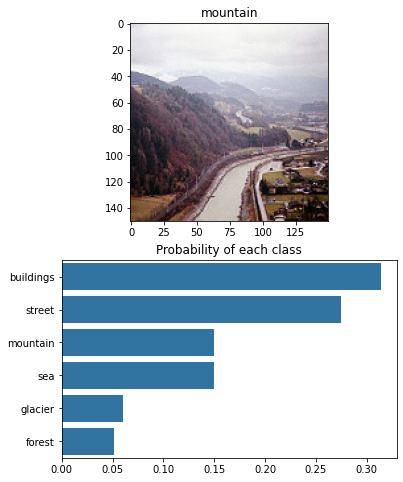

The image was classified incorrectly.


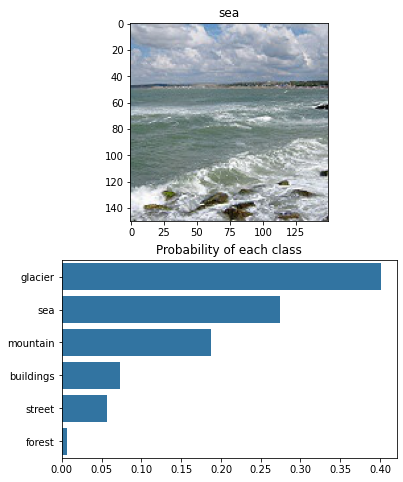

The image was classified incorrectly.


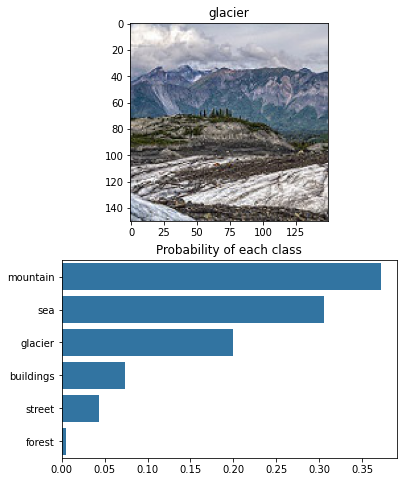

The image was classified incorrectly.


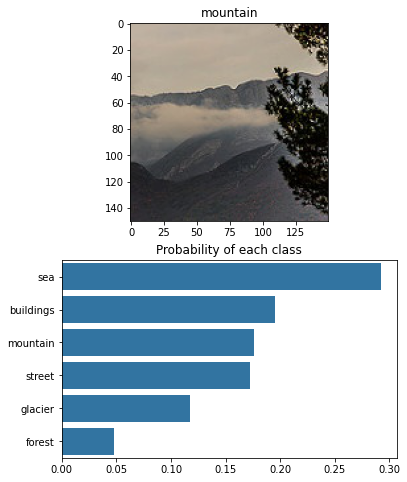

The image was classified incorrectly.


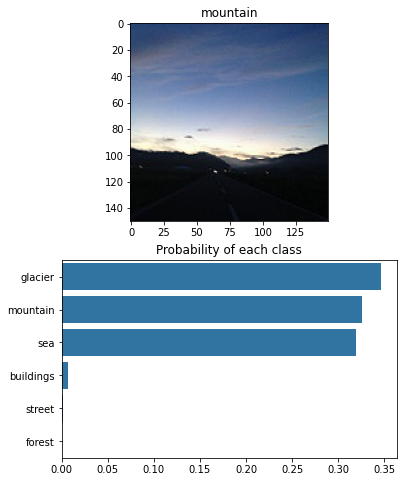

The image was classified incorrectly.


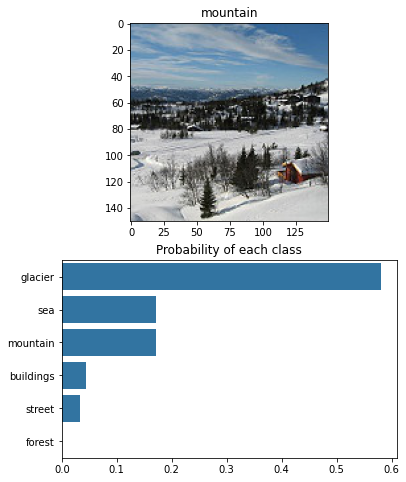

The image was classified incorrectly.


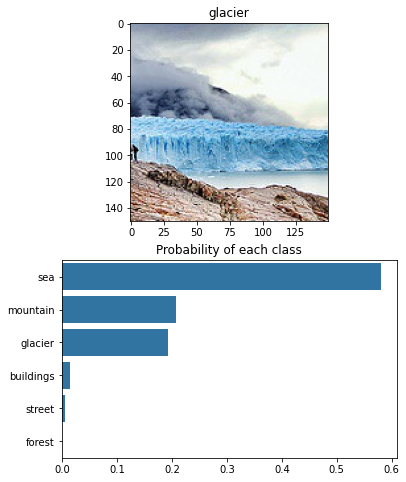

The image was classified incorrectly.


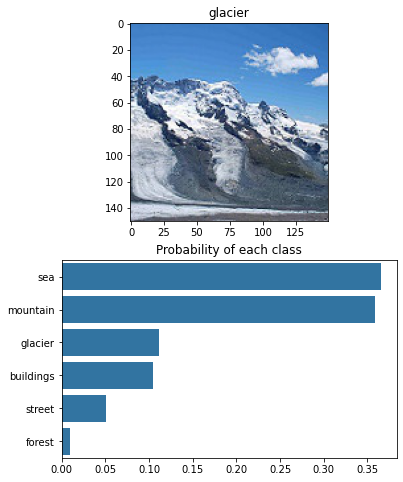

The image was classified incorrectly.


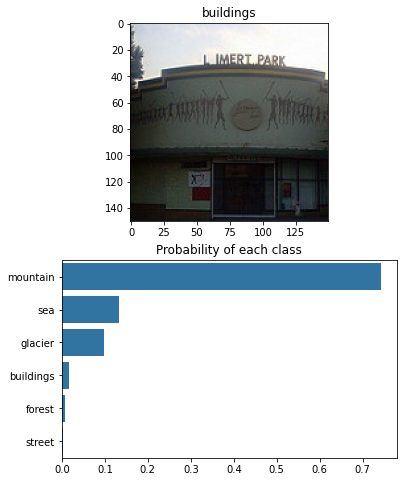

The image was classified incorrectly.


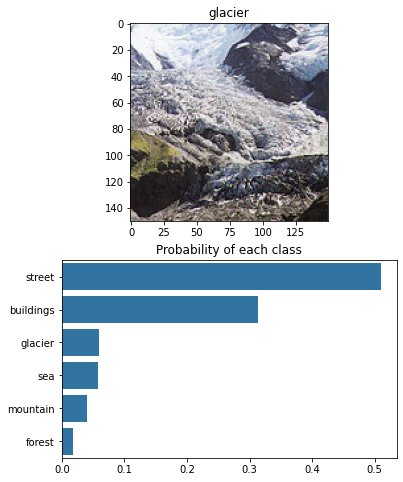

The image was classified incorrectly.


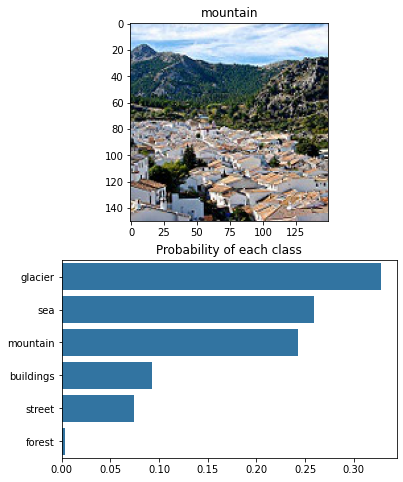

The image was classified incorrectly.


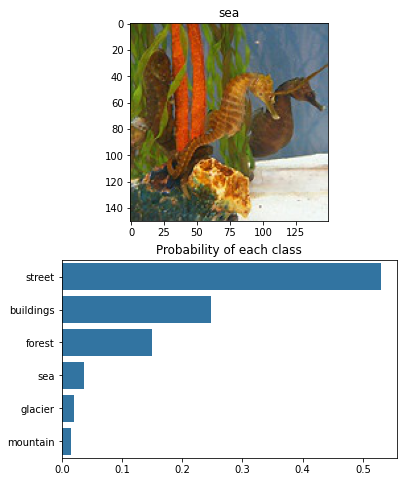

The image was classified incorrectly.


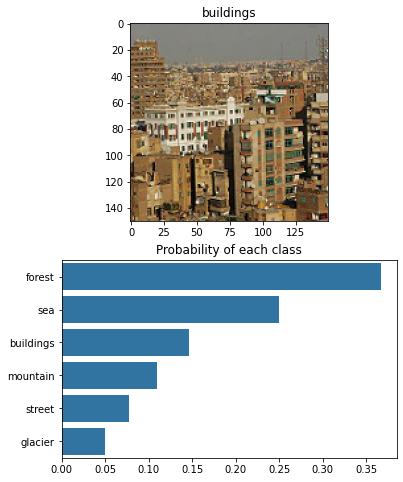

The image was classified incorrectly.


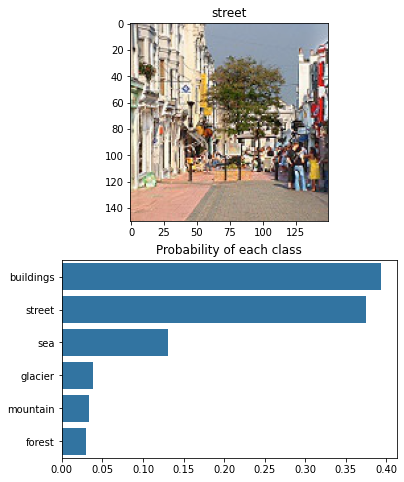

The image was classified incorrectly.


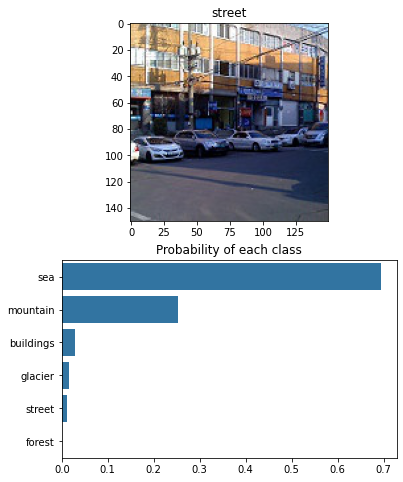

The image was classified incorrectly.


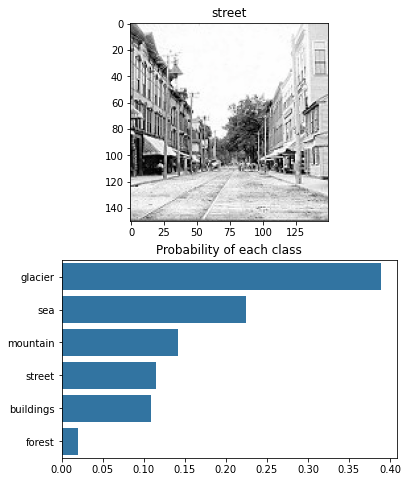

The image was classified incorrectly.


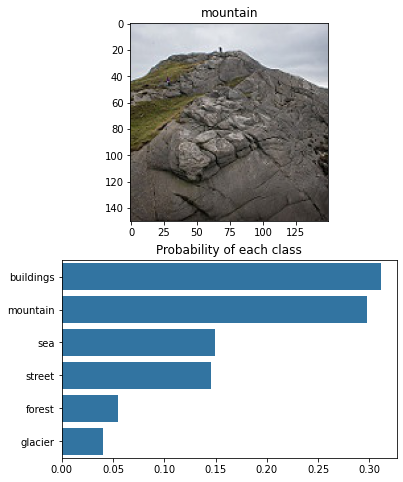

The image was classified incorrectly.


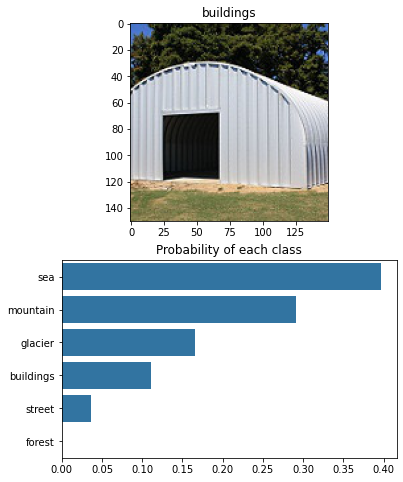

The image was classified incorrectly.


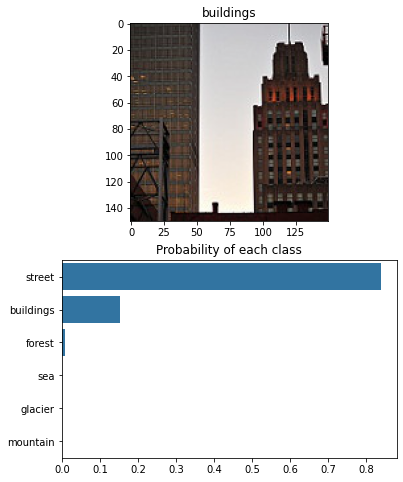

The image was classified incorrectly.


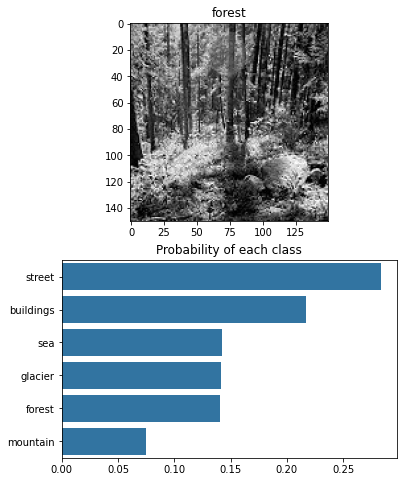

The image was classified incorrectly.


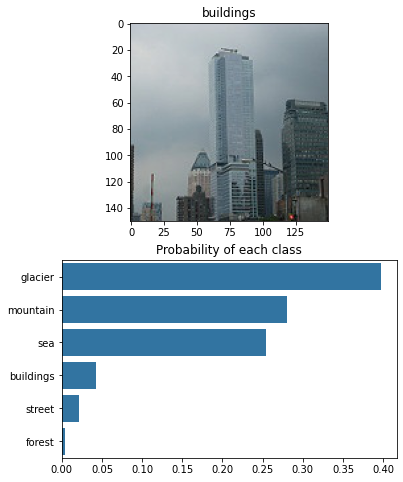

The image was classified incorrectly.


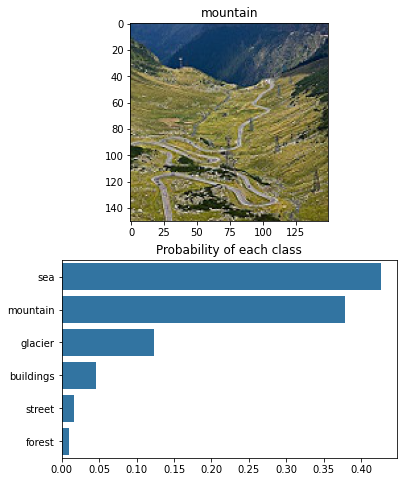

The image was classified incorrectly.


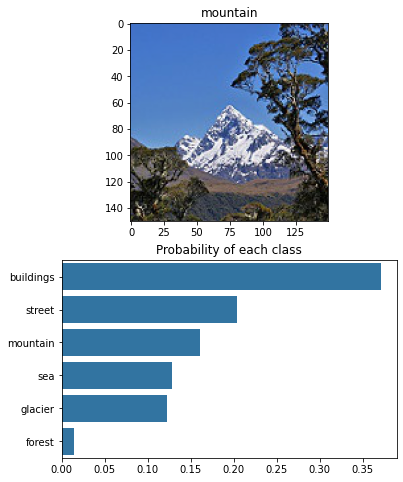

The image was classified incorrectly.


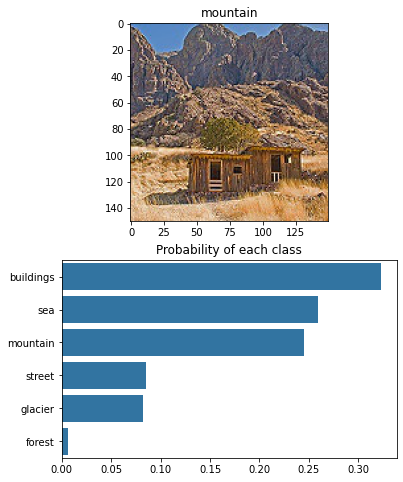

The image was classified incorrectly.


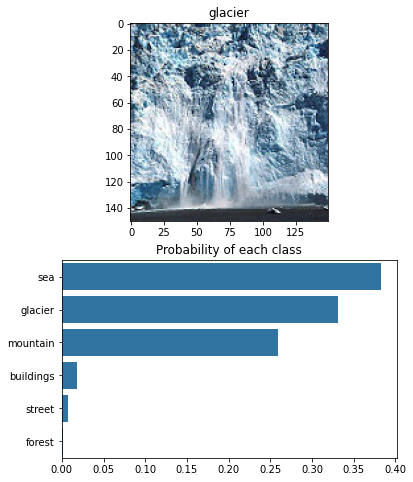

The image was classified incorrectly.


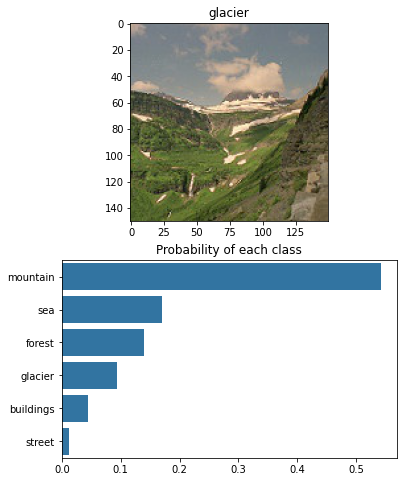

The image was classified incorrectly.


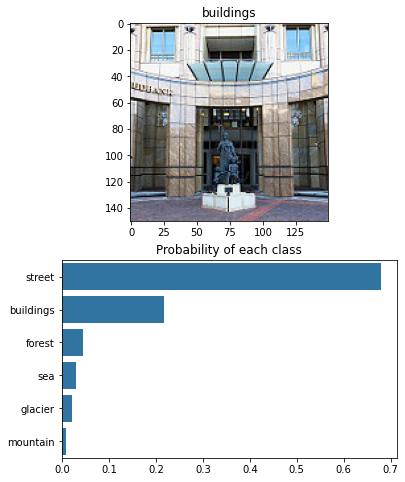

The image was classified incorrectly.


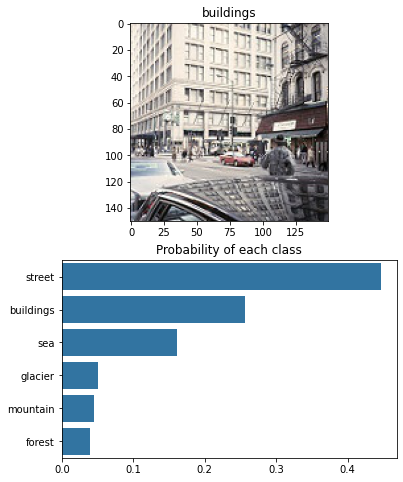

The image was classified incorrectly.


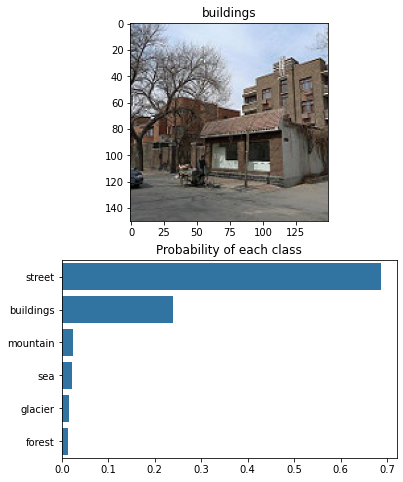

The image was classified incorrectly.


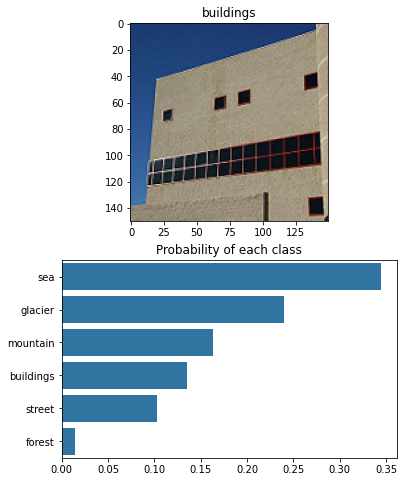

The image was classified incorrectly.


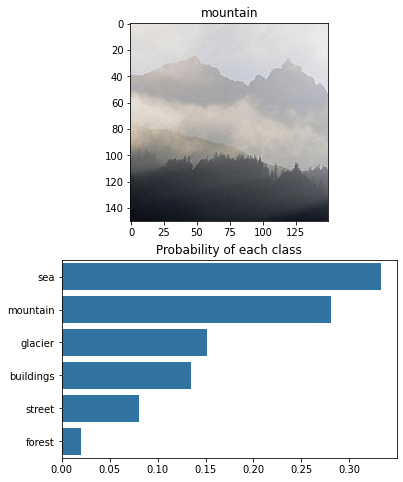

The image was classified incorrectly.


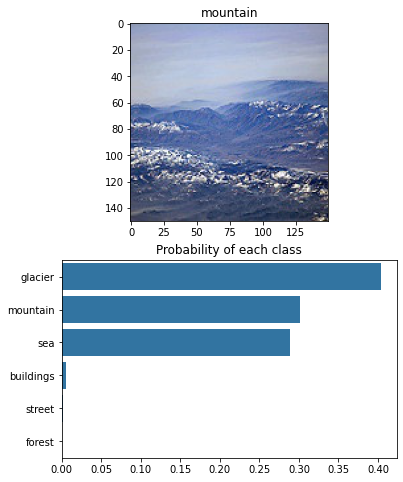

The image was classified incorrectly.


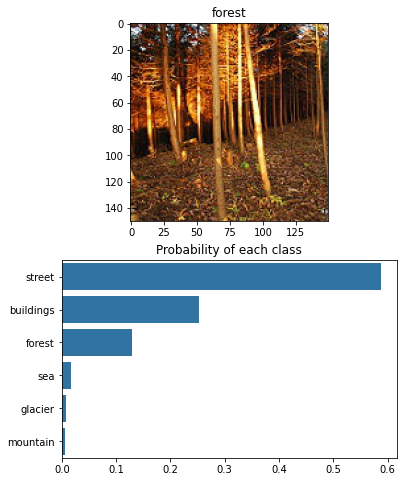

The image was classified incorrectly.


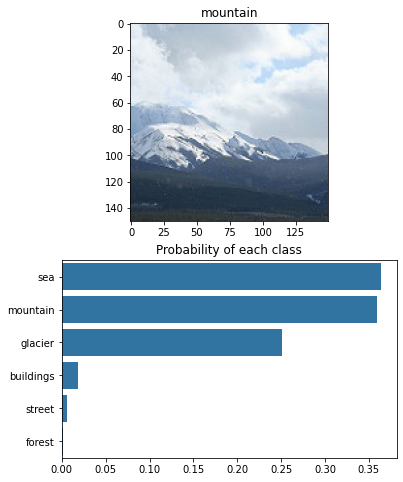

The image was classified incorrectly.


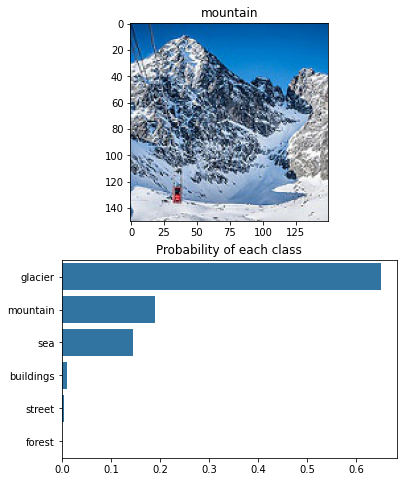

The image was classified incorrectly.


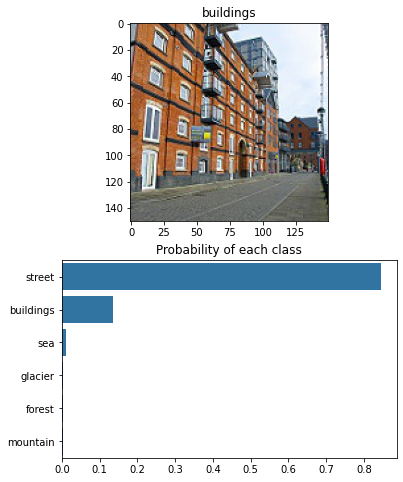

The image was classified incorrectly.


In [32]:
# Get the misclassfied data
with torch.no_grad():
  model.eval()
  classes = ["buildings", "forest", "glacier", "mountain", "sea", "street"]
  dataiter = iter(test_loader)
  images, labels = dataiter.next()
  images, labels = images.to(device), labels.to(device)
  outputs = model(images)
  outputs = outputs.cpu()
  print("Plotting misclassified data:")
  # Iterate through each image in the batch
  for i in range(len(labels)):
    outputs = model(images)
    outputs = outputs.cpu()
    output = (torch.exp(outputs[i]))
    prob, idx = torch.topk(output,6)
    # If the prediction does not match the label, plot the image and its prediction
    if labels[i] != idx[0]:
      plt.figure(figsize=(6,8))
      ax = plt.subplot(2,1,1)
      images = images.cpu()
      imshow(torchvision.utils.make_grid(images[i]), ax, title=classes[labels[i]], normalized = True) # normalized = True for augmented (CNN), false for non augmented (ANN)
      images = images.to(device)
      plt.subplot(2,1,2)
      topsix= [classes[i] for i in idx]
      sns.barplot(x=prob, y=topsix,color=sns.color_palette()[0])
      plt.title("Probability of each class")
      plt.show() 
      print("The image was classified incorrectly.")

https://github.com/bentrevett/pytorch-image-classification/blob/master/4%20-%20VGG.ipynb

In [0]:
# Using sklearn's confusion matrix plot
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (7, 7));
    plt.title("Confusion Matrix (Multi-class)")
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


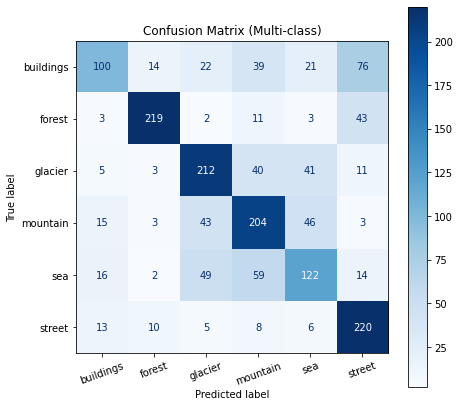

In [36]:
plot_confusion_matrix(labels, pred_labels, classes)

# Non-augmented training samples to training loss anc accuracy calculation
Non augmented train loader was used to obtain the loss and accuracy when training with augmented data. But, the training time has more than quadrupled which makes thid method infeasible.


In [0]:
# Using non augmented train loader to obtain the training loss and accuracy

# save = '/Data/model.pt'

# def train(model,
#           criterion,
#           optimizer,
#           train_loader,
#           valid_loader,
#           train_nonaug_loader,
#           save_file,
#           early_stop_epochs=8,
#           epochs = 100):
  
#   start_training_time = time.time()
#   start = time.time()
#   history = []
#   epochs_no_improve = 0
#   valid_loss_min = np.Inf

#   valid_max_acc = 0
#   print("The training process has started. \n")
#   for e in range(epochs):
#       running_loss = 0
#       model.train() 
#       total_train = 0
#       correct_train = 0
#       steps = 0
      
#       for ii, (inputs, labels) in tqdm(enumerate(train_loader),total=len(train_loader),desc='Epoch progress'):
#           steps += 1
          
#           inputs, labels = inputs.to(device), labels.to(device)
          
#           optimizer.zero_grad()
          
#           # Forward and backward passes
#           outputs = model.forward(inputs)
#           loss = criterion(outputs, labels)
#           loss.backward()
#           optimizer.step()
          
#           running_loss += loss.item()
          
#           # _, predicted = torch.max(outputs,1)
#           # total_train += labels.nelement()
#           # correct_train += predicted.eq(labels).sum().item()
#           # train_acc = correct_train/total_train
#       model.eval()

#       with torch.no_grad():
#           valid_loss, valid_acc = validation(model, valid_loader, criterion)
#           train_loss, train_acc = validation(model, train_nonaug_loader, criterion)

#       print("Epoch: {}/{} | ".format(e+1, epochs),
#             "Training Loss: {:.4f} | ".format(train_loss/len(train_loader)),
#             "Training Accuracy: {:.2f}% |".format(100*train_acc/len(train_loader)),
#             "Validation Loss: {:.4f} | ".format(valid_loss/len(valid_loader)),
#             "Validation Accuracy: {:.2f}% |".format(100*valid_acc/len(valid_loader)),
#             "Time elapsed: {:.2f} seconds".format((time.time()-start)))
#       start = time.time()
#       history.append([train_loss/len(train_loader),100*train_acc/len(train_loader),valid_loss/len(valid_loader),100*valid_acc/len(valid_loader)])
#       if valid_loss/len(valid_loader) < valid_loss_min:
#         torch.save(model.state_dict(), save_file)
#         epochs_no_improve = 0
#         valid_loss_min = valid_loss/len(valid_loader)
#         valid_best_acc = 100*valid_acc/len(valid_loader)
#         best_epoch = e+1
#       else:
#         epochs_no_improve += 1
#         if epochs_no_improve >= early_stop_epochs:
#           print("Early Stopping...Total epochs: {}. Best epoch: {} with loss: {:4f} and accuracy: {:.2f}".format(e+1,best_epoch,valid_loss_min,valid_best_acc))
#           model.load_state_dict(torch.load(save_file))
#           model.optimizer = optimizer
#           history = pd.DataFrame(
#                     history,
#                     columns=['train_loss','train_acc', 'valid_loss', 'valid_acc'])
#           return model, history


#       model.train()
#   end_training_time = time.time()
#   model.load_state_dict(torch.load(save_file))
#   model.optimizer = optimizer
#   history = pd.DataFrame(
#     history,
#     columns=['train_loss','train_acc', 'valid_loss', 'valid_acc'])
#   print('\nTraining of the model was completed in {:.2f} minutes.'.format((end_training_time-start_training_time)/60))
#   return model, history